# Display Plots

In [81]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.evaluate_utils import *
%matplotlib inline

### Set model and dataset to evaluate


In [82]:
# Define directories and filenames
model_name = '20230210-0333'
set_name = 'Test'
data_model= '3'

In [83]:
#directories
gt_dir = '../data/CARDIAC'
result_dir = f'../results/Temporal4DFlowNet_{model_name}'
eval_dir = f'{result_dir}/plots'
lr_dir = '../data/CARDIAC'
model_dir = '../models'

#filenames
gt_filename = f'M{data_model}_2mm_step5_static.h5'
lr_filename = f'M{data_model}_2mm_step5_static_TLR.h5'
result_filename = f'{set_name}set_result_model{data_model}_2_{model_name[-4::]}_temporal_new.h5'
evaluation_filename = f'eval_rel_err_{data_model}_2_{model_name[-4::]}_temporal.h5'
model_filename = f'Temporal4DFlowNet_{model_name}/Temporal4DFlowNet-best.h5'


if not os.path.isdir(eval_dir):
    os.makedirs(eval_dir)

#Params for evalation
save_relative_error_file= False

# Setting up
gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
res_filepath = '{}/{}'.format(result_dir, result_filename)
lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
model_path = '{}/{}'.format(model_dir, model_filename)


if save_relative_error_file:
    assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

vel_colnames=['u', 'v', 'w']
gt = {}
lr = {}
pred = {}
dt = {}

with h5py.File(res_filepath, mode = 'r' ) as h_pred:
    with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
        with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
            
            gt["mask"] = np.asarray(h_gt["mask"])
            gt["mask"][np.where(gt["mask"] !=0)] = 1
            temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])

            # adapt dimension
            for vel in vel_colnames:
                
                gt[vel] = np.asarray(h_gt[vel])
                pred[vel] = np.asarray(h_pred[vel])
                lr[vel]= np.asarray(h_lr[vel])

                #transpose for temporal resolution
                pred[vel] = pred[vel].transpose(1, 0, 2, 3)

                pred[f'{vel}_fluid'] = np.multiply(pred[vel], temporal_mask)
                lr[f'{vel}_fluid'] = np.multiply(lr[vel], temporal_mask[::2, :, :, :])
                gt[f'{vel}_fluid'] = np.multiply(gt[vel], temporal_mask)
                
            

print()


In [84]:
rel_error = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, err_u, err_v, err_w = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

max/min before arctan 68880.91 0.0
max/min after arctan 1.5707818 0.0


## Show results including non-fluid region
 

In [85]:
min_v = np.min([np.min(pred['u']), np.min(gt['u']), np.min(lr['u'])])
max_v = np.max([np.max(pred['u']), np.max(pred['u']), np.max(lr['u'])])  

min_v = -0.15
max_v = 0.15

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 0, vel = "u"):
    plt.subplot(1, 3, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v, vmax = max_v)#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v, vmax = max_v)#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v, vmax = max_v)#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v, vmax = max_v)#, cmap='jet')
    plt.title("SR")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



interactive(children=(IntSlider(value=5, description='frame', max=19), IntSlider(value=0, description='x', max…

## Show results with only fluid region

In [86]:
min_v = np.min([np.min(pred['u_fluid']), np.min(gt['u_fluid']), np.min(lr['u_fluid'])])
max_v = np.max([np.max(pred['u_fluid']), np.max(pred['u_fluid']), np.max(lr['u_fluid'])])  
print(min_v)
print(max_v)
min_v = -0.15
max_v = 0.15

vel_colnames = ['u_fluid', 'v_fluid', 'w_fluid']

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 0, vel = "u"):
    plt.subplot(1, 4, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v, vmax = max_v, cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v, vmax = max_v, cmap='viridis')
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v, vmax = max_v, cmap='viridis')#, origin = 'lower')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v, vmax = max_v, cmap='viridis')
    plt.axis('off')


    plt.subplot(1, 4, 4)
    plt.imshow(error_pointwise[frame, x, :, :], cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    #plt.colorbar()
    plt.show()

-1.893865942955017
0.4724928140640259


interactive(children=(IntSlider(value=5, description='frame', max=19), IntSlider(value=0, description='x', max…

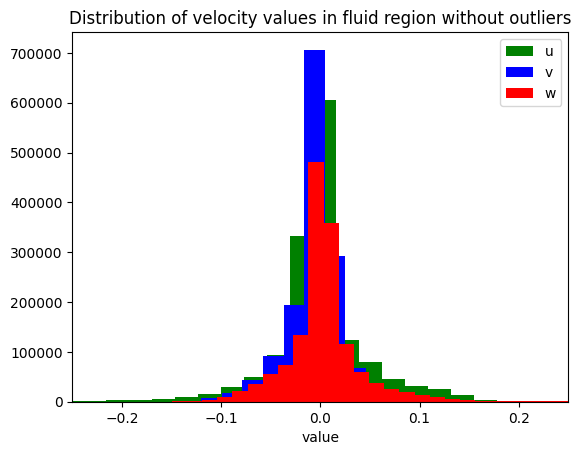

In [87]:
plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 100, color='g', label = 'u')
plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 100,  color='b', label = 'v')
plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 100,  color='r', label = 'w')
plt.xlim(-0.25, 0.25)
plt.xlabel('value')
plt.xlabel('value')
plt.title("Distribution of velocity values in fluid region without outliers")
plt.legend()
plt.show()

### Calculate relative error 

max/min before arctan 68880.91 0.0
max/min after arctan 1.5707818 0.0


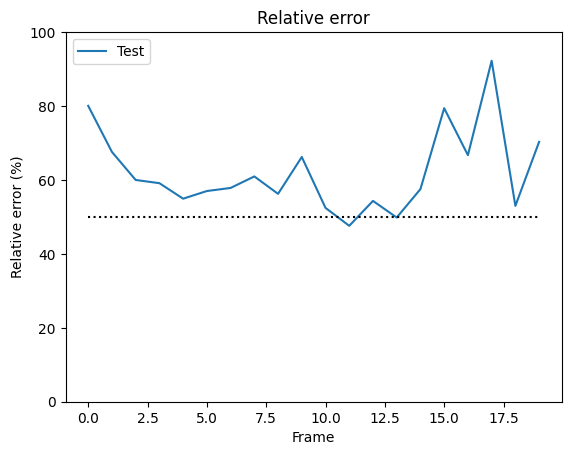

In [88]:
plot_relative_error([gt_filepath],[res_filepath], [set_name], save_as=f'{eval_dir}/relative_error.png')
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'

### Plot regression lines

Plotting regression lines...


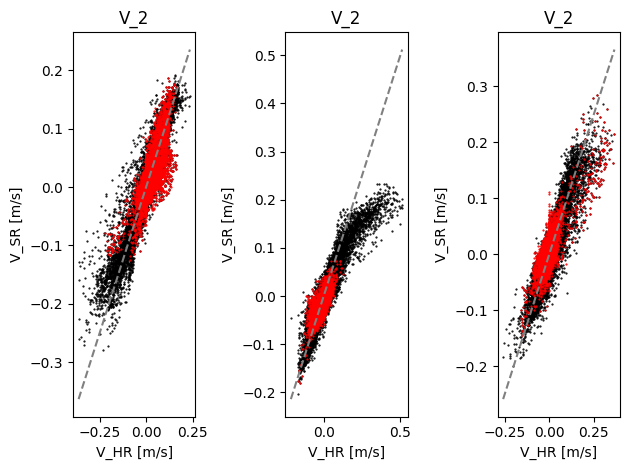

In [89]:
plot_regression(gt, pred, frame_idx=9, save_as=f'{eval_dir}/Plot_regression.png')
plt.tight_layout()

In [90]:
#show_timeframes(gt,lr,  pred,mask, rel_error, dt,  timepoints, axis, idx, save_as = "Frame_comparison.png")


